In [1]:
from utils import find_REM, load_data
REM_files = find_REM()
REM_files[:5]

[PosixPath('/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD16_OR_20210701/2021-07-02_12-28-46_posttrial4/REM_data.npz'),
 PosixPath('/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD16_OR_20210701/2021-07-02_11-38-01_posttrial3/REM_data.npz'),
 PosixPath('/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD16_OR_20210701/2021-07-02_13-19-27_posttrial5/REM_data.npz'),
 PosixPath('/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD5_HC_20210609/2021-06-09_13-36-38_posttrial5/REM_data.npz'),
 PosixPath('/home/miranjo/REM_Phasic-Tonic/data/rat3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD5_HC_20210609/2021-06-09_10-15-22_posttrial1/REM_data.npz')]

In [6]:
len(REM_files)

102

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy import signal, stats, ndimage
from scipy import ndimage, interpolate

import pandas as pd
import glmtools as glm

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series

import emd



def my_range(x):
    return x.max() - x.min()

def compute_range(x):
    return x.max() - x.min()


def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

def decorate_ax(ax):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
        
def load_tracking(whl_path, new_len, smoothing=1):
    """Load position data from .whl file"""
    track = np.genfromtxt( whl_path )
    track[track<0] = np.nan
    if smoothing is not None:
            track = ndimage.filters.gaussian_filter1d(track, smoothing, axis=0)

    pixels2bins = 37 / (np.nanmax(track[:,0])-np.nanmin(track[:,0])) * 1/32. * 1250
    velx = np.gradient(track[:,0])
    vely = np.gradient(track[:,1])
    speed = np.sqrt(pow(velx,2)+pow(vely,2))

    # Upsample to match LFP data
    factor = 1250/32
    f = interpolate.interp1d( np.linspace(0,track.shape[0]/factor,track.shape[0]), speed,
                       kind='nearest', bounds_error=False)
    big_speed= f( np.linspace(0,new_len/1250, new_len) )*pixels2bins

    return big_speed

def load_dataset(run_id):
    logger = logging.getLogger('emd')

    inds = np.where([r == run_id for r in config['recordings']])[0][0]
    fileName = config['recordings'][inds]+'.eeg'
    logger.info('Loading data from: {0}'.format(fileName))
    raw = np.fromfile(fileName, dtype=np.int16).astype(float)
    raw = raw.reshape(-1,64)[:,config['tetrode_inds'][inds]]
    sample_rate = 1250
    seconds = raw.shape[0] / sample_rate
    time = np.linspace(0,seconds,raw.shape[0])
    logger.info('Loaded {0} seconds of data'.format(seconds))
    fileWhl = config['recordings'][inds]+'.whl'
    logger.info('Loading tracking from: {0}'.format(fileWhl))
    speed = load_tracking(fileWhl, time.shape[0], smoothing=16)

    return raw, speed, time, sample_rate

def getIMFmainfreq(If, Ia):
    '''
    If the instantaneous frequency extracted from imfs
    Ia instantenous amplitude 
    '''
    IF = If.transpose()
    IA = Ia.transpose()

    nimfs = np.size(IA,0)

    mainfreqs = np.zeros(nimfs)+np.nan
    for imfi in range(0,nimfs):
        if0 = np.copy(IF[imfi,1:-1])
        ia0 = np.copy(IA[imfi,1:-1])
        mainfreqs[imfi] = np.sum(if0*pow(ia0,2))/np.sum(pow(ia0,2))
    return mainfreqs


def remove_frames(ax, tags=['top', 'right']):
    for tag in tags:
        ax.spines[tag].set_visible(False)

def decorate(ax, mode='timex', bottom_row=True):
    for tag in ['top', 'right']:
        ax.spines[tag].set_visible(False)
    if mode == 'phasex':
        if bottom_row:
            xlabels = ['-pi', '-pi/2', '0', 'pi/2', 'pi']
            ax.set_xlabel('Theta Phase (rads)')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 5))
        ax.set_xticklabels(xlabels)
    elif mode == 'timex':
        if bottom_row:
            xlabels = np.arange(5)*50
            ax.set_xlabel('Time (samples)')
        else:
            xlabels = []
        ax.set_xticks(np.arange(5)*50)
        ax.set_xticklabels(xlabels)
    elif mode == 'normx':
        if bottom_row:
            xlabels = np.linspace(0, 1, 3)
            ax.set_xlabel('Proportion of sinusoid')
        else:
            xlabels = []
        ax.set_xticks(np.linspace(0, 48, 3))
        ax.set_xticklabels(xlabels)

def shift_ax(ax, shift):
    pos = list(ax.get_position().bounds)
    pos[0] = pos[0] + shift
    ax.set_position(pos)

def phase_from_freq(ifrequency, sample_rate, phase_start=-np.pi):
    """
    Compute the instantaneous phase of a signal from its instantaneous phase.
    Parameters
    ----------
    ifrequency : ndarray
        Input array containing the instantaneous frequencies of a signal
    sample_rate : scalar
        The sampling frequency of the data
    phase_start : scalar
         Start value of the phase output (Default value = -np.pi)
    Returns
    -------
    IP : ndarray
        The instantaneous phase of the signal
    """

    iphase_diff = (ifrequency / sample_rate) * (2 * np.pi)

    iphase = phase_start + np.cumsum(iphase_diff, axis=0)

    iphase = np.r_[phase_start, iphase]

    return iphase

def get_cycle_examples():
    from scipy import interpolate
    freq = 8
    seconds = 2/freq
    num_samples = 3124

    time_vect = np.linspace(0, seconds, num_samples)

    phs = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    tim2 = [0, 390-100, 781, 1171+100, 1562]
    tim3 = [0, 390+100, 781, 1171-100, 1562]
    tim4 = [0, 390-150, 781, 1171+150, 1562]

    pin2 = interpolate.interp1d(tim2, phs, kind='quadratic')
    pin3 = interpolate.interp1d(tim3, phs, kind='quadratic')
    pin4 = interpolate.interp1d(tim4, phs, kind='quadratic')

    xx2 = pin2(np.arange(1562))
    xx3 = pin3(np.arange(1562))
    xx4 = pin4(np.arange(1562))

    x = np.zeros((3124, 5))
    x[:, 0] = -np.cos(2*np.pi*8*time_vect)
    x[:, 1] = np.r_[np.sin(xx4), np.sin(xx4), np.sin(xx4)][1171:1171+3124]
    x[:, 2] = np.flipud(x[:, 1])
    x[:, 3] = -np.r_[np.cos(xx2), np.cos(xx2)]
    x[:, 4] = -np.r_[np.cos(xx3), np.cos(xx3)]
    return time_vect, x

def add_circles(ax, waves=False, sines=False,
                wave_len=.5, wave_height=1, offset=3):

    x_polar = np.linspace(0, 2*np.pi, 128)
    factor = np.array([.5, 1])*2
    for f in factor:
        ax.plot(f*np.sin(x_polar), f*np.cos(x_polar), 'k', linewidth=.75)
    ax.plot((-2.5, 2.5), (0, 0), 'k', linewidth=.75)
    ax.plot((0, 0), (-2.5, 2.5), 'k', linewidth=.75)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    ax.set_xticks([])
    ax.set_yticks([])

    tv, canonical_cycles = get_cycle_examples()
    canonical_cycles = canonical_cycles*wave_height
    tv /= 15
    tv2 = np.linspace(0, wave_len, 3124)

    if sines:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]-offset, 'k', linewidth=.5)
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 0]+offset, 'k', linewidth=.5)
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 0], 'k', linewidth=.5)

    if waves:
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 3]-offset, 'k')
        ax.plot(tv2-wave_len/2, canonical_cycles[:, 4]+offset, 'k')
        ax.plot(tv2-offset-wave_len/2, canonical_cycles[:, 2], 'k')
        ax.plot(tv2+offset-wave_len/2, canonical_cycles[:, 1], 'k')
        

def normalised_waveform(infreq, sample_rate):
    sr = infreq.mean() * len(infreq)
    phase_diff = (infreq / sr) * (2 * np.pi)
    phase = np.cumsum(phase_diff, axis=0)
    phase = np.r_[0, phase]
    sine = np.sin(np.linspace(0, 2*np.pi, len(phase)))
    nw = np.sin(phase)

    return nw, sine

def plot_signal(lfpREM, sig_low, times, title):
    xlim = (4, 10)
    tidx = np.logical_and(times >= xlim[0], times < xlim[1])

    plot_time_series(times[tidx], [lfpREM[tidx], sig_low[tidx]], colors=['k', 'k'], alpha=[.5, 1], lw=2)
    plt.title(title + ' timeseries ')
    plt.show()

def scatter_kde(x, y):
    # Calculate the point density
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)

    # KDE colouring
    plt.scatter(x, y, c=z, s=5, edgecolor=['none'])

(4.0, 6.0)

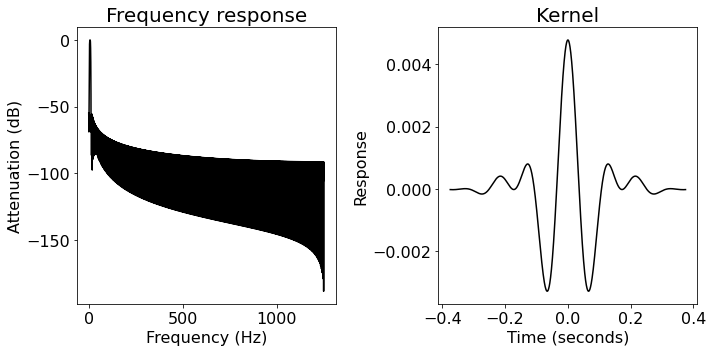

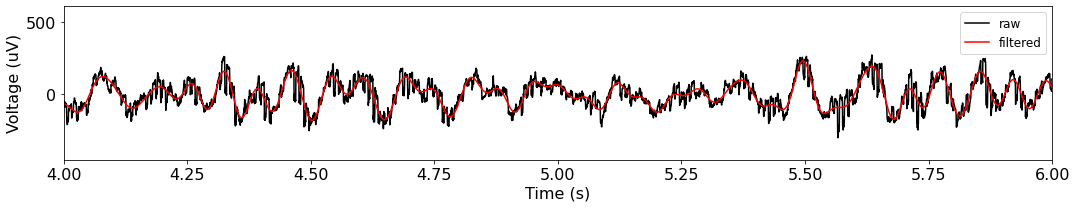

In [31]:
# Filter settings
f_theta = (4, 12)
f_lowpass = 20
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

# Loading the data from the iterator
rem = REM_files[3]
dataREM = load_data(rem)
lfpREM = dataREM[7]

times = np.arange(0, len(lfpREM)/fs, 1/fs)


#Filtering the signal
sig_low = filter_signal(lfpREM, fs, 'lowpass', f_lowpass, n_seconds=n_seconds_filter, remove_edges=False)
sig_filt = filter_signal(lfpREM, fs, 'bandpass', (4, 10), n_seconds=.75, plot_properties=True)

#plot_signal(lfpREM, sig_low, times, '')
plot_time_series(times, [lfpREM, sig_low], ['raw', 'filtered'])
plt.xlim(4,6)

# Now plotting the data to inspect them
#plt.plot(sig_filt)
#plt.xlim((1,5000))
#plt.xlabel('Sample')
#plt.ylabel('Amplitude $\mu$V')
#print('Procced')

In [32]:
# Doing the EMD analysis to extract theta oscillations
print('Masked Sift Instantaneous Frequency Setting')
imf, mf =emd.sift.iterated_mask_sift(sig_low,mask_0='if',ret_mask_freq='True')

Masked Sift Instantaneous Frequency Setting


[4.54862628e-03 2.18400128e-03 8.15346774e-04 2.81389336e-04
 1.68465896e-04 6.53338070e-05]
[11.38787641  5.46327045  2.06907619  0.75555099  0.41391698  0.17384015]
Finished section 1 in the analysis


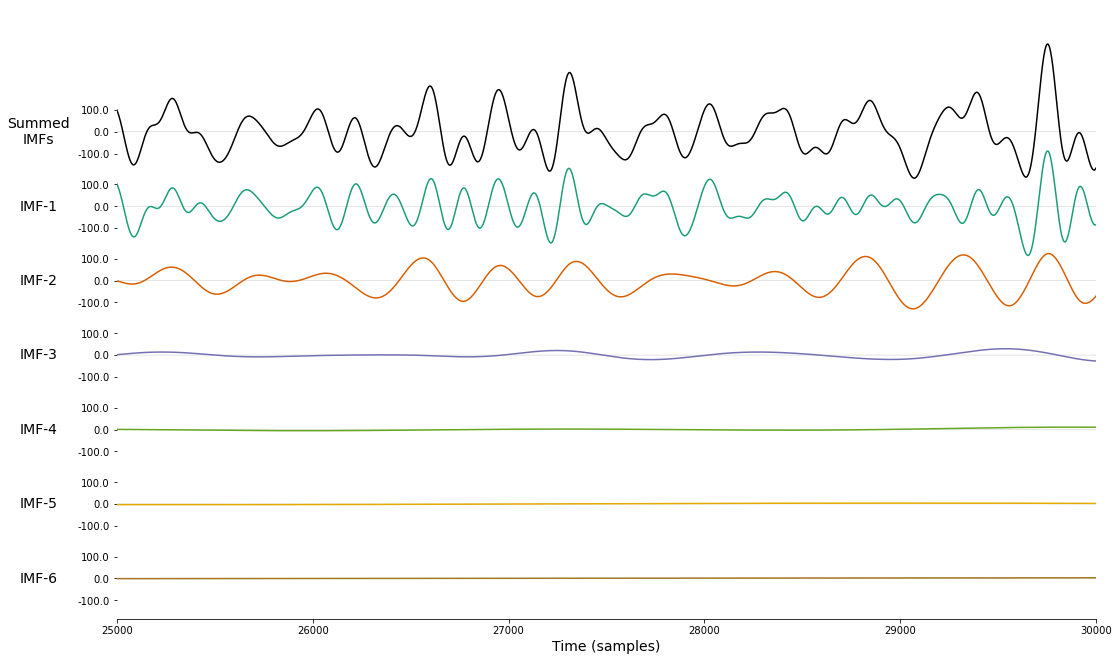

In [34]:
# extract the phase, instantaneous frequency and amplitude
sample_rate = fs
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert', smooth_phase=3)
# you use the filtered theta signal
# we plot the results from the masked frequencies
emd.plotting.plot_imfs(imf)
plt.xlim((25000,30000))

# print the masked frequencies 
print(mf)

# print the frequency component for each imf 
A = getIMFmainfreq(IF, IA)
print(A)
print('Finished section 1 in the analysis')

In [35]:
componentI = 2

C = emd.cycles.Cycles(IP[:, componentI])
display(C)

<class 'emd.cycles.Cycles'> (55 cycles 1 metrics) 

In [36]:
# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', imf[:, componentI], emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', imf[:, componentI], emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', imf[:, componentI], emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', imf[:, componentI], emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', imf[:, componentI], len)

C.compute_cycle_metric('max_amp', IA[:, componentI], np.max)
C.compute_cycle_metric('mean_if', IF[:, componentI], np.mean)
C.compute_cycle_metric('max_if', IF[:, componentI], np.max)
C.compute_cycle_metric('range_if', IF[:, componentI], compute_range)

C.compute_cycle_metric('asc2desc', imf[:, componentI], asc2desc)
C.compute_cycle_metric('peak2trough', imf[:, componentI], peak2trough)

print('Finished computing the cycles metrics')

Finished computing the cycles metrics


In [37]:
display(C)

<class 'emd.cycles.Cycles'> (55 cycles 13 metrics) 

In [38]:
df = C.get_metric_dataframe()
df.head()

,is_good,start_sample,stop_sample,peak_sample,desc_sample,trough_sample,duration_samples,max_amp,mean_if,max_if,range_if,asc2desc,peak2trough
0,0,0,-0.069103,None,None,None,126,26.409571,7.792674,73.247052,70.091801,NaN,NaN
1,1,126,-0.014865,247.816565,532.037037,770.410895,1049,23.765486,2.383755,3.137661,0.977333,0.501817,0.507185
2,1,1175,-0.013472,316.477515,673.483483,974.01597,1382,14.684960,1.808305,2.339033,0.935455,0.524212,0.487325
3,1,2557,-0.008393,525.840988,798.302302,1060.045744,1407,8.979788,1.777272,2.096480,1.028599,0.620324,0.567379
4,1,3964,-0.085590,392.067598,633.496496,940.059623,1175,18.305392,2.126707,2.377168,0.540281,0.533624,0.539146


In [39]:
good_cycles = C.get_matching_cycles(['is_good==1'])
len(good_cycles)

55

In [16]:
print('{0} matching cycles found'.format(np.sum(good_cycles)))


4186 matching cycles found


In [17]:
df = C.get_metric_dataframe(conditions='is_good==1')
print(df)

      index  is_good  start_sample  stop_sample peak_sample desc_sample  \
0         1        1            44    -2.018895   16.847655   27.868869   
1         4        1           189    -2.246229    9.520358   24.175175   
2         5        1           244    -1.543213   11.959004   21.960961   
3         6        1           298    -2.170786   17.896563   32.593594   
4         8        1           430    -1.680020   11.297082   24.845846   
...     ...      ...           ...          ...         ...         ...   
4181   5402        1        240929    -2.720013   23.387084   34.451451   
4182   5404        1        241064    -0.800106   15.851862   28.296296   
4183   5407        1        241137    -2.252927   14.200247   24.713714   
4184   5408        1        241185    -0.076181   11.450995   23.504505   
4185   5409        1        241238    -1.538644   16.426975   28.820821   

     trough_sample  duration_samples    max_amp    mean_if     max_if  \
0        39.177424        